This tutorial demonstrates the most important basic steps involved in the analysis of scanning (precession) electron diffraction (S(P)ED) data. 

# Change Log

20/10/18 Duncan Johnstone - Updated for pyXem 0.6

22/03/18 Duncan Johnstone & Phillip Crout - Updated for ePSIC Hyperspy Workshop

08/06/17 Duncan Johnstone - Developed for Trondheim Diffraction Workshop

# Requirements

pyXem 0.6 & all dependencies

# Materials & Methods

SPED data was acquired from a GaAs nanowire, which exhibits type I twinning along its length. This material was kindly provided by Prof. Ton van Helvoort (NTNU) and was grown by molecular beam epitaxy.

# Contents

1. <a href='#loa'> Loading & Inspection</a>
2. <a href='#cal'> Alignment & Calibration</a>
3. <a href='#vdf'> Virtual Diffraction Imaging</a>
4. <a href='#ml'> Machine Learning SPED Data</a>
5. <a href='#vec'> Peak Finding & Vector Analysis</a>
6. <a href='#ori'> Indexation & Orientation Mapping</a>

Import pyXem and other required libraries

In [1]:
%matplotlib tk
import pyxem as pxm
import numpy as np

# <a id='loa'></a> 1. Loading and Inspection

Load the SPED data acquired from the nanowire

In [2]:
dp = pxm.load('./nanowire_sed_example.hdf5')
dp = pxm.ElectronDiffraction(dp)

Look at what kind of object 'dp' is

In [3]:
dp.data.dtype

dtype('uint8')

Inspect the metadata associated with the object 'dp'

In [4]:
dp.metadata

├── General
│   └── title = 
└── Signal
    ├── binned = False
    └── signal_type = electron_diffraction

Set important experimental parameters using the built in function

In [5]:
dp.set_experimental_parameters(accelerating_voltage=300.,
                               camera_length=21.,
                               scan_rotation=277.,
                               convergence_angle=0.7,
                               exposure_time=10.)

See how this changed the metadata

In [6]:
dp.metadata

├── Acquisition_instrument
│   └── TEM
│       ├── Detector
│       │   └── Diffraction
│       │       ├── camera_length = 21.0
│       │       └── exposure_time = 10.0
│       ├── accelerating_voltage = 300.0
│       ├── convergence_angle = 0.7
│       └── scan_rotation = 277.0
├── General
│   └── title = 
└── Signal
    ├── binned = False
    └── signal_type = electron_diffraction

Set another metadata item and check it

In [7]:
dp.metadata.set_item("General.title", 'GaAs Nanowire')
dp.metadata

├── Acquisition_instrument
│   └── TEM
│       ├── Detector
│       │   └── Diffraction
│       │       ├── camera_length = 21.0
│       │       └── exposure_time = 10.0
│       ├── accelerating_voltage = 300.0
│       ├── convergence_angle = 0.7
│       └── scan_rotation = 277.0
├── General
│   └── title = GaAs Nanowire
└── Signal
    ├── binned = False
    └── signal_type = electron_diffraction

Plot the data to inspect it

In [8]:
dp.plot()

## <a id='cal'></a> 2. Alignment & Calibration

Apply distortion corrections to the data due to off-axis acquisition

In [9]:
dp.apply_affine_transformation(np.array([[0.99,0,0],
                                         [0,0.69,0],
                                         [0,0,1]]),
                               preserve_range=True)

In [10]:
dp.data.dtype

dtype('float64')

Align the dataset based on the direct beam position

In [11]:
dp.center_direct_beam(radius_start=2,
                      radius_finish=5,
                      square_width=10)

In [12]:
dp.plot()

Measure known interplanar spacing to obtain calibration

In [14]:
dpm = dp.mean((0,1))
dpm.plot()

In [15]:
line = pxm.roi.Line2DROI(x1=25.2428, y1=65.7885, x2=120.297, y2=78.2273, linewidth=5.49734)
line.add_widget(dpm)

In [16]:
trace = line(dpm)
trace.plot()

In [17]:
recip_d111 = np.sqrt((3/5.6535**2))
recip_cal = recip_d111 / 11.4

Set data calibrations

In [18]:
dp.set_diffraction_calibration(recip_cal)
dp.set_scan_calibration(10)

Plot the calibrated data

In [19]:
dp.plot()

## <a id='vdf'></a> 3. Virtual Diffraction Imaging & Selecting Regions

### 3.1 Interactive VDF Imaging

Plot an interactive virtual image integrating intensity within a circular subset of pixels in the diffraction pattern

In [20]:
roi = pxm.roi.CircleROI(cx=0.,cy=0, r_inner=0, r=0.07)
dp.plot_interactive_virtual_image(roi=roi)

Get the virtual diffraction image associated with the last integration window used interactively

In [21]:
vdf = dp.get_virtual_image(roi)

Plot the virtual dark-field image

In [22]:
vdf.plot()

Save the virtual dark-field image as a 32bit tif

In [ ]:
vdf.change_dtype('float32')
vdf.save('vdfeg.tif')

### 3.2 Form multiple images using a VDF Generator

Import the VDFGenerator class

In [23]:
from pyxem.generators.vdf_generator import VDFGenerator

Initialize the VDFGenerator

In [24]:
vdfgen = VDFGenerator(dp)

Calculate 10 annular VDF images between 0 and 1 reciprocal angstroms

In [25]:
vdfs = vdfgen.get_concentric_vdf_images(k_min=0,
                                        k_max=1,
                                        k_steps=10)

Plot the VDF images

In [26]:
vdfs.plot()

Save the stack of VDF image as a 32bit tif stack

In [ ]:
vdfs.change_dtype('float32')
vdfs.save('vdsfeg.tif')

### 3.3 Select a region in the scan

Plot the data with an adjustable marker indicating where to crop the scan region

In [27]:
reg = pxm.roi.RectangularROI(left=50, top=630, right=290, bottom=870)
dp.plot()
reg.add_widget(dp)

Crop the dataset based on the region defined above

In [28]:
dpc = reg(dp)

Calculate the mean diffraction pattern from the selected region

In [29]:
dpcm = dpc.mean((0,1))

Plot the mean diffraction pattern from the selected region

In [30]:
dpcm.plot()

# <a id='ml'></a> 4. Unsupervised learning

Perform singular value decomposition (SVD) of the data

In [31]:
dpc.change_dtype('float')
dpc.decomposition(True, algorithm='svd')

Obtain a "Scree plot" by plotting the fraction of variance described by each principal component

In [32]:
dpc.plot_explained_variance_ratio()

Plot the decomposition results and have a look at them

In [33]:
dpc.plot_decomposition_results()

Perform non-negative matrix factorisation (NMF)

In [34]:
dpc.decomposition(True, algorithm='nmf', output_dimension=3)

Plot the NMF results

In [35]:
dpc.plot_decomposition_results()

Check the signal type of dpc -- decomposition has reassigned it to Signal2D

In [36]:
dpc

<Signal2D, title: GaAs Nanowire, dimensions: (24, 24|144, 144)>

Reassign the signal type to ElectronDiffraction

In [37]:
dpc = pxm.ElectronDiffraction(dpc)
dpc.set_diffraction_calibration(recip_cal)
dpc.set_scan_calibration(10)
dpc

<ElectronDiffraction, title: , dimensions: (24, 24|144, 144)>

In [38]:
dpc.plot()

## 5. Azimuthal Integration & Background Subtraction

Obtain an aximuthially integrated diffraction profile and plot it

In [39]:
rp = dpc.get_radial_profile()

Plot the electron diffraction profile at every probe position

In [60]:
rp.plot()

Perform a background subtraction

In [41]:
dpb = dpc.remove_background(method='median', footprint=12)

Plot the background subtracted electron diffraction data

In [47]:
dpb.plot()

## <a id='vec'></a> 6. Peak Finding & Vector Analysis

Interactively tune peak finding parameters

In [ ]:
dpc.find_peaks_interactive()

Perform peak finding on all diffraction patterns in data

In [43]:
peaks = dpc.find_peaks(method='difference_of_gaussians',
                       min_sigma=1.,
                       max_sigma=6.,
                       sigma_ratio=1.6,
                       threshold=0.04,
                       overlap=0.99)

Check the peaks object type

In [44]:
peaks

<DiffractionVectors, title: , dimensions: (24, 24|)>

Look at what's in the peaks object

In [45]:
peaks.data

array([[array([[-0.01343719, -0.01343719],
       [-0.06718594, -0.28218094],
       [-0.36280407, -0.30905532]]),
        array([[ 0.33592969,  0.30905532],
       [ 0.04031156,  0.28218094],
       [ 0.28218094,  0.04031156],
       [-0.01343719, -0.01343719],
       [-0.28218094, -0.04031156],
       [-0.06718594, -0.28218094],
       [-0.36280407, -0.30905532]]),
        array([[ 0.33592969,  0.30905532],
       [ 0.04031156,  0.28218094],
       [ 0.28218094,  0.04031156],
       [-0.01343719, -0.01343719],
       [-0.28218094, -0.04031156],
       [-0.06718594, -0.28218094],
       [-0.36280407, -0.33592969]]),
        array([[ 0.33592969,  0.30905532],
       [ 0.04031156,  0.28218094],
       [ 0.28218094,  0.04031156],
       [-0.01343719, -0.01343719],
       [-0.28218094, -0.06718594],
       [-0.57779907, -0.09406031],
       [-0.06718594, -0.30905532],
       [-0.33592969, -0.33592969]]),
        array([[ 0.33592969,  0.30905532],
       [ 0.06718594,  0.25530657],
       

Plot the found peak positions

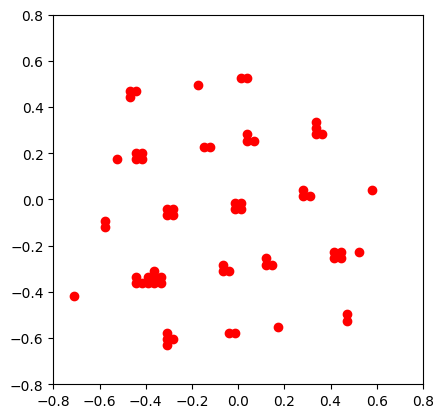

In [46]:
peaks.plot_diffraction_vectors(xlim=0.8, ylim=0.8, distance_threshold=0.01)

Plot found peak positions as an overlay on the data

In [56]:
peaks.plot_diffraction_vectors_on_signal(dpc, cmap='viridis', vmax=50)

Form a diffracting pixels map to show where peaks were found

In [57]:
crystim = peaks.get_diffracting_pixels_map(binary=False)

Plot the diffracting pixels map

In [58]:
crystim.plot(cmap='viridis')

Produce a histogram of diffraction vector magnitudes

In [59]:
bins = np.arange(0, 1.5, recip_cal)
ghist = peaks.get_magnitude_histogram(bins=bins)
ghist.plot()

/home/hremadmin/anaconda3/lib/python3.6/site-packages/hyperspy/external/astroML/histtools.py:291: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if bins == 'blocks':
/home/hremadmin/anaconda3/lib/python3.6/site-packages/hyperspy/external/astroML/histtools.py:293: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif bins == 'knuth':
/home/hremadmin/anaconda3/lib/python3.6/site-packages/hyperspy/external/astroML/histtools.py:295: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif bins == 'scotts':
/home/hremadmin/anaconda3/lib/python3.6/site-packages/hyperspy/external/astroML/histtools.py:297: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif bins == 'freedman':
/home

### 6.1 Imaging using found diffraction conditions

Produce virtual diffraction contrast images for all diffraction vectors

In [61]:
from pyxem.generators.vdf_generator import VDFGenerator

In [62]:
vdfgen = VDFGenerator(dpc, peaks)

In [63]:
vdfs = vdfgen.get_vector_vdf_images(radius=recip_cal*3)

In [64]:
vdfs.plot()

## <a id='ori'></a> 7. Indexation & Orientation Mapping

### 7.1 Define theoretical structure & orientation library

In [65]:
import diffpy.structure

Build crystal structure

In [66]:
a = 5.6535
latt = diffpy.structure.lattice.Lattice(a,a,a,90,90,90)

In [67]:
atom_list = []
for coords in [[0,0,0],[0.5,0,0.5],[0,0.5,0.5],[0.5,0.5,0]]:
    x,y,z = coords[0],coords[1],coords[2]
    atom_list.append(diffpy.structure.atom.Atom(atype='Ga',xyz=[x,y,z],lattice=latt)) # Motif part A
    atom_list.append(diffpy.structure.atom.Atom(atype='As',xyz=[x+0.25,y+0.25,z+0.25],lattice=latt)) # Motif part B

In [68]:
structure = diffpy.structure.Structure(atoms=atom_list,lattice=latt)

Simulate a library of 2D diffraction patterns for all symmetry inequivalent orientations

In [71]:
from pyxem.libraries.structure_library import StructureLibrary

In [72]:
structure_lib = StructureLibrary(['GaAs'],[structure],[[(0,45,0),(0,-45,0)]])

### 7.2 Simulate 2D diffraction library

Set up diffraction simulator

In [69]:
edc = pxm.DiffractionGenerator(300, 5e-2)

In [73]:
diff_gen = pxm.DiffractionLibraryGenerator(edc)

In [74]:
diffraction_lib = diff_gen.get_diffraction_library(structure_lib,
                                                   calibration=recip_cal,
                                                   reciprocal_radius=1.,
                                                   half_shape=(72,72),
                                                   with_direct_beam=False)

### 7.3 Match 2D library to data

Find the best matching simulated diffraction pattern for every experimental pattern

In [75]:
from pyxem.generators.indexation_generator import IndexationGenerator

In [77]:
indexer = IndexationGenerator(dpc, diffraction_lib)

In [78]:
match_results = indexer.correlate()

IndexError: list index out of range

Plot the position of strong peaks in the simulated data overlaying the experimental data for visual inspection

In [ ]:
from pyxem.utils.sim_utils import peaks_from_best_template
from pyxem.utils.plot import generate_marker_inputs_from_peaks
import hyperspy.api as hs

In [ ]:
match_peaks = match_results.map(peaks_from_best_template,phase=["A"],library=library,inplace=False)

mmx,mmy = generate_marker_inputs_from_peaks(match_peaks)
dpb.plot(cmap='viridis')
for mx,my in zip(mmx,mmy):
    m = hs.markers.point(x=mx,y=my,color='red',marker='x')
    dpb.add_marker(m,plot_marker=True,permanent=True)

Obtain an orientation map from the matching results

In [ ]:
cryst_map = match_results.get_crystallographic_map()
ori_map = cryst_map.get_orientation_image()
ori_map.plot()

### 7.4 Vector Based Indexation

Index peaks based on diffraction vector magnitude

In [70]:
sim_prof = edc.calculate_profile_data(structure=structure,
                                      reciprocal_radius=1.3)

In [ ]:
sim_prof.plot(g_max=1.3)

In [ ]:
gmags = peaks.get_magnitudes()

In [ ]:
indexer = ProfileIndexationGenerator(gmags, sim_prof, mapping=False)

In [ ]:
results = indexer.index_peaks(tolerance=0.1)